# SARL for Portfolio Management on DJ30
This tutorial is to demonstrate an example of using SARL to do portfolio management on DJ30

## Step1: Import Packages

In [1]:
import warnings

warnings.filterwarnings("ignore")
import sys
from pathlib import Path
import os
import torch

ROOT = os.path.dirname(os.path.abspath("."))
sys.path.append(ROOT)
from trademaster.utils import plot
import argparse
import os.path as osp
from mmcv import Config
from trademaster.utils import replace_cfg_vals
from trademaster.datasets.builder import build_dataset
from trademaster.trainers.builder import build_trainer
from trademaster.utils import set_seed
set_seed(2023)

2023-03-04 18:50:30,910	INFO services.py:1476 -- View the Ray dashboard at http://127.0.0.1:8267
2023-03-04 18:50:32,917	INFO worker.py:973 -- Calling ray.init() again after it has already been called.


## Step2: Import Configs

In [2]:

parser = argparse.ArgumentParser(description='Download Alpaca Datasets')
parser.add_argument("--config", default=osp.join(ROOT, "configs", "portfolio_management", "portfolio_management_dj30_sarl_sarl_adam_mse.py"),
                    help="download datasets config file path")
parser.add_argument("--task_name", type=str, default="train")
args, _ = parser.parse_known_args()

cfg = Config.fromfile(args.config)
task_name = args.task_name
cfg = replace_cfg_vals(cfg)

In [3]:
cfg

Config (path: /data/sunshuo/qml/TradeMaster/configs/portfolio_management/portfolio_management_dj30_sarl_sarl_adam_mse.py): {'data': {'type': 'PortfolioManagementDataset', 'data_path': 'data/portfolio_management/dj30', 'train_path': 'data/portfolio_management/dj30/train.csv', 'valid_path': 'data/portfolio_management/dj30/valid.csv', 'test_path': 'data/portfolio_management/dj30/test.csv', 'tech_indicator_list': ['high', 'low', 'open', 'close', 'adjcp', 'zopen', 'zhigh', 'zlow', 'zadjcp', 'zclose', 'zd_5', 'zd_10', 'zd_15', 'zd_20', 'zd_25', 'zd_30'], 'length_day': 5, 'initial_amount': 10000, 'transaction_cost_pct': 0.001, 'test_dynamic_path': 'data/portfolio_management/dj30/DJI_label_by_DJIindex_3_24_-0.25_0.25.csv'}, 'environment': {'type': 'PortfolioManagementSARLEnvironment'}, 'trainer': {'type': 'PortfolioManagementSARLTrainer', 'agent_name': 'ddpg', 'if_remove': False, 'configs': {'framework': 'tf2', 'num_workers': 0}, 'work_dir': 'work_dir/portfolio_management_dj30_sarl_sarl_adam_m

## Step3: Build Dataset

In [4]:
dataset = build_dataset(cfg)

## Step4: Build Trainer

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
work_dir = os.path.join(ROOT, cfg.trainer.work_dir)

if not os.path.exists(work_dir):
    os.makedirs(work_dir)
cfg.dump(osp.join(work_dir, osp.basename(args.config)))

trainer = build_trainer(cfg, default_args=dict(dataset=dataset, device = device))

| Arguments Keep work_dir: /data/sunshuo/qml/TradeMaster/work_dir/portfolio_management_dj30_sarl_sarl_adam_mse


## Step5: Train, Valid and Test

In [6]:
trainer.train_and_valid()

2023-03-04 18:50:35,319	INFO trainer.py:2322 -- Executing eagerly (framework='tf2'), with eager_tracing=False. For production workloads, make sure to set eager_tracing=True  in order to match the speed of tf-static-graph (framework='tf'). For debugging purposes, `eager_tracing=False` is the best choice.
2023-03-04 18:50:35,321	WARNING deprecation.py:47 -- DeprecationWarning: `config['prioritized_replay']` has been deprecated. Replay prioritization specified at new location config['replay_buffer_config']['prioritized_replay'] will be overwritten. This will raise an error in the future!
2023-03-04 18:50:35,322	WARNING deprecation.py:47 -- DeprecationWarning: `config[prioritized_replay_alpha]` has been deprecated. config['replay_buffer_config'][prioritized_replay_alpha] should be used for Q-Learning algorithms. Ignore this warning if you are not using a Q-Learning algorithm and still provide prioritized_replay_alpha. This will raise an error in the future!
2023-03-04 18:50:35,322	WARNING 

Train Episode: [1/2]


Valid Episode: [1/2]
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
|  8.418111%   |   0.410622  | 2.239796%  |  34.994217%  |
+--------------+-------------+------------+--------------+
Train Episode: [2/2]
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
| -23.813643%  |  -0.205806  | 0.799392%  |  62.305931%  |
+--------------+-------------+------------+--------------+
Valid Episode: [2/2]
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
|  10.970900%  |   0.475267  | 2.276330%  |  35.440930%  |
+--------------+-------------+------------+--------------+


In [7]:
import ray
from ray.tune.registry import register_env
from trademaster.environments.portfolio_management.sarl_environment import PortfolioManagementSARLEnvironment
def env_creator(env_name):
    if env_name == 'portfolio_management_sarl':
        env = PortfolioManagementSARLEnvironment
    else:
        raise NotImplementedError
    return env
ray.init(ignore_reinit_error=True)
register_env("portfolio_management_sarl", lambda config: env_creator("portfolio_management_sarl")(config))
trainer.test();

2023-03-04 19:03:01,742	INFO services.py:1476 -- View the Ray dashboard at http://127.0.0.1:8267
2023-03-04 19:03:04,049	WARNING deprecation.py:47 -- DeprecationWarning: `config['prioritized_replay']` has been deprecated. Replay prioritization specified at new location config['replay_buffer_config']['prioritized_replay'] will be overwritten. This will raise an error in the future!
2023-03-04 19:03:04,050	WARNING deprecation.py:47 -- DeprecationWarning: `config[prioritized_replay_alpha]` has been deprecated. config['replay_buffer_config'][prioritized_replay_alpha] should be used for Q-Learning algorithms. Ignore this warning if you are not using a Q-Learning algorithm and still provide prioritized_replay_alpha. This will raise an error in the future!
2023-03-04 19:03:04,051	WARNING deprecation.py:47 -- DeprecationWarning: `config[prioritized_replay_beta]` has been deprecated. config['replay_buffer_config'][prioritized_replay_beta] should be used for Q-Learning algorithms. Ignore this wa

Test Best Episode
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
|  13.393640%  |   1.111919  | 0.772255%  |  7.716845%   |
+--------------+-------------+------------+--------------+


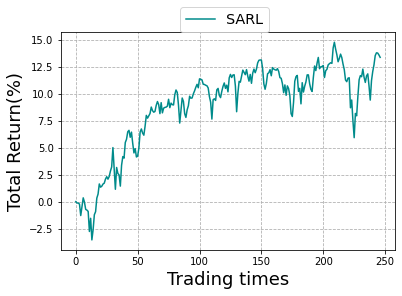

In [8]:
plot(trainer.test_environment.save_asset_memory(),alg="SARL")